## Survival prediction QC

In general, we've found that fitting survival models from scikit-survival to high-dimensional -omics data has been fairly error-prone. In particular, our models will often fail to converge: either there will be no valid hyperparameter combination in the search path that results in non-zero/NaN coefficients, or the predictor from the train set will make nonsensical predictions on the test data.

To ensure that our scripts will continue to run, we generally do one of two things when model convergence fails: 1) skip writing a results file entirely (this happens when the model fails to train or make predictions altogether), or 2) write a results file with a default c-index of 0.5 for the given CV fold (this happens when one CV fold fails to find a valid hyperparameter combination but other folds are fine).

In this script, we'll check for both. Both of these cases will fail silently when we actually plot the results, so we use this script to get an idea of how often models are failing to converge.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directories
me_results_dir = Path(cfg.results_dirs['survival'], 'me_ridge')
me_baseline_results_dir = Path(cfg.results_dirs['survival'], 'me_ridge_baseline')

all_results_dir = Path(cfg.results_dirs['survival'], 'all_ridge')
all_baseline_results_dir = Path(cfg.results_dirs['survival'], 'all_ridge_baseline')

# set list of PCA component numbers to look for
pcs_list = [10, 100]

### Count results files, expression vs. methylation

In [3]:
# get baseline predictor results, using non-omics covariates only
me_all_results_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    try:
        me_pcs_dir = Path(me_results_dir, 'results_{}_pca'.format(n_dim))
        me_results_df = su.load_survival_results(me_pcs_dir)
        me_results_df.rename(columns={'identifier': 'cancer_type',
                                      'fold_no': 'fold'}, inplace=True)
        me_results_df['n_dim'] = n_dim
        me_all_results_df.append(me_results_df)
    except FileNotFoundError:
        # just skip if certain dimension didn't run
        continue
    
me_all_results_df = pd.concat(me_all_results_df)
me_all_results_df = me_all_results_df.reset_index(drop=True)

print(me_all_results_df.shape)
print(me_all_results_df.n_dim.unique())
print(me_all_results_df.training_data.unique())
me_all_results_df.head()

(5664, 8)
[ 10 100]
['expression' 'me_450k' 'me_27k']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.97443,train,PCPG,expression,signal,1,0,10
1,0.97443,cv,PCPG,expression,signal,1,0,10
2,0.22137,test,PCPG,expression,signal,1,0,10
3,0.88533,train,PCPG,expression,signal,1,1,10
4,0.88533,cv,PCPG,expression,signal,1,1,10


In [4]:
# count the number of failed fits per cancer type/training data/n_dim
count_df = (me_all_results_df
    .groupby(['cancer_type', 'training_data', 'n_dim', 'signal'])
    .count()
)[['cindex']]

count_df.rename(columns={'cindex': 'results_count'}, inplace=True)
count_df.reset_index(inplace=True)
count_df.head(10)

,cancer_type,training_data,n_dim,signal,results_count
0,ACC,expression,10,shuffled,24
1,ACC,expression,10,signal,24
2,ACC,expression,100,shuffled,12
3,ACC,expression,100,signal,24
4,ACC,me_27k,10,shuffled,24
5,ACC,me_27k,10,signal,24
6,ACC,me_27k,100,signal,24
7,ACC,me_450k,10,shuffled,24
8,ACC,me_450k,10,signal,24
9,ACC,me_450k,100,signal,24


Text(0.5, 1.0, 'Number of results files per cancer type, 10 dims, shuffled')

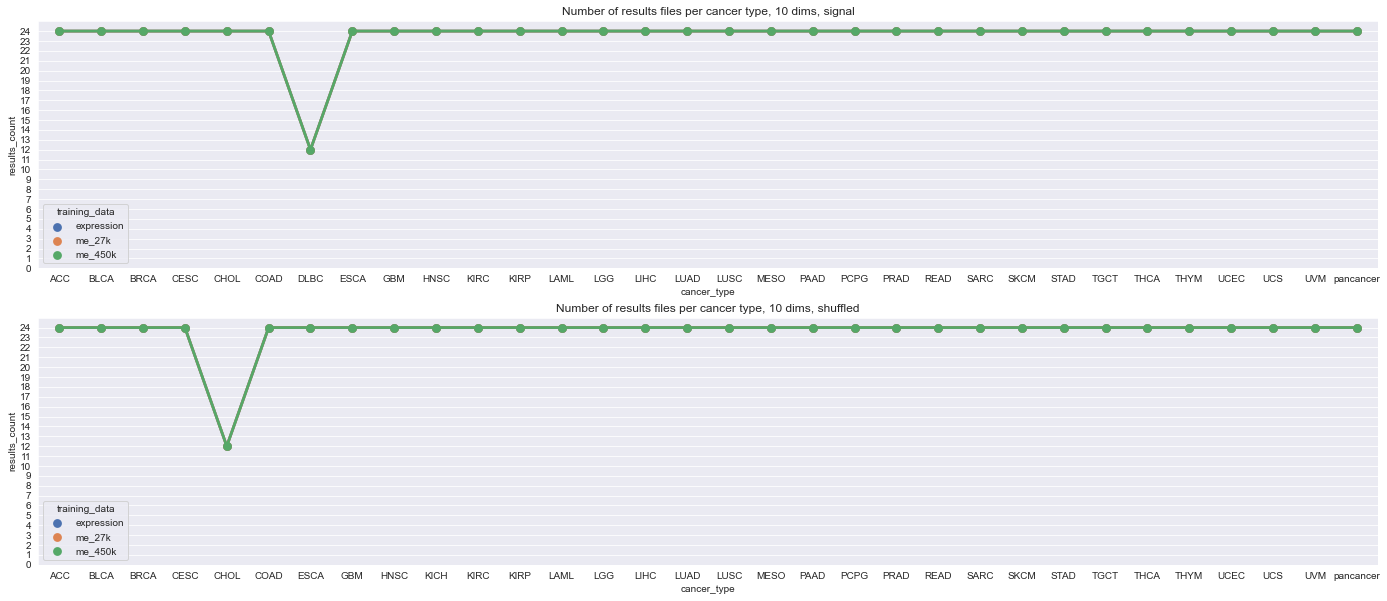

In [5]:
n_dim = 10

sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=count_df[(count_df.signal == 'signal') & (count_df.n_dim == n_dim)],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[0])
axarr[0].set_ylim(0, 25)
axarr[0].set_yticks(range(0, 25))
axarr[0].set_title('Number of results files per cancer type, {} dims, signal'.format(n_dim))

sns.pointplot(data=count_df[(count_df.signal == 'shuffled') & (count_df.n_dim == n_dim)],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[1])
axarr[1].set_ylim(0, 25)
axarr[1].set_yticks(range(0, 25))
axarr[1].set_title('Number of results files per cancer type, {} dims, shuffled'.format(n_dim))

### Count results files, all data types

In [6]:
# get baseline predictor results, using non-omics covariates only
all_all_results_df = []

for n_dim in pcs_list:
    # load results into a single dataframe
    try:
        all_pcs_dir = Path(all_results_dir, 'results_{}_pca'.format(n_dim))
        all_results_df = su.load_survival_results(all_pcs_dir)
        all_results_df.rename(columns={'identifier': 'cancer_type',
                                      'fold_no': 'fold'}, inplace=True)
        all_results_df['n_dim'] = n_dim
        all_all_results_df.append(all_results_df)
    except FileNotFoundError:
        # just skip if certain dimension didn't run
        continue
    
all_all_results_df = pd.concat(all_all_results_df)
all_all_results_df = all_all_results_df.reset_index(drop=True)

print(all_all_results_df.shape)
print(all_all_results_df.n_dim.unique())
print(all_all_results_df.training_data.unique())
all_all_results_df.head()

(7620, 8)
[10]
['me_450k' 'rppa' 'mut_sigs' 'expression' 'me_27k' 'mirna']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.82877,train,ACC,me_450k,shuffled,1,0,10
1,0.82877,cv,ACC,me_450k,shuffled,1,0,10
2,0.91667,test,ACC,me_450k,shuffled,1,0,10
3,0.78947,train,ACC,me_450k,shuffled,1,1,10
4,0.78947,cv,ACC,me_450k,shuffled,1,1,10


In [7]:
# count the number of failed fits per cancer type/training data/n_dim
count_df = (all_all_results_df
    .groupby(['cancer_type', 'training_data', 'n_dim', 'signal'])
    .count()
)[['cindex']]

count_df.rename(columns={'cindex': 'results_count'}, inplace=True)
count_df.reset_index(inplace=True)
count_df.head(10)

,cancer_type,training_data,n_dim,signal,results_count
0,ACC,expression,10,shuffled,24
1,ACC,expression,10,signal,24
2,ACC,me_27k,10,shuffled,24
3,ACC,me_27k,10,signal,24
4,ACC,me_450k,10,shuffled,24
5,ACC,me_450k,10,signal,24
6,ACC,mirna,10,shuffled,24
7,ACC,mirna,10,signal,24
8,ACC,mut_sigs,10,shuffled,24
9,ACC,mut_sigs,10,signal,24


Text(0.5, 1.0, 'Number of results files per cancer type, 10 dims, shuffled')

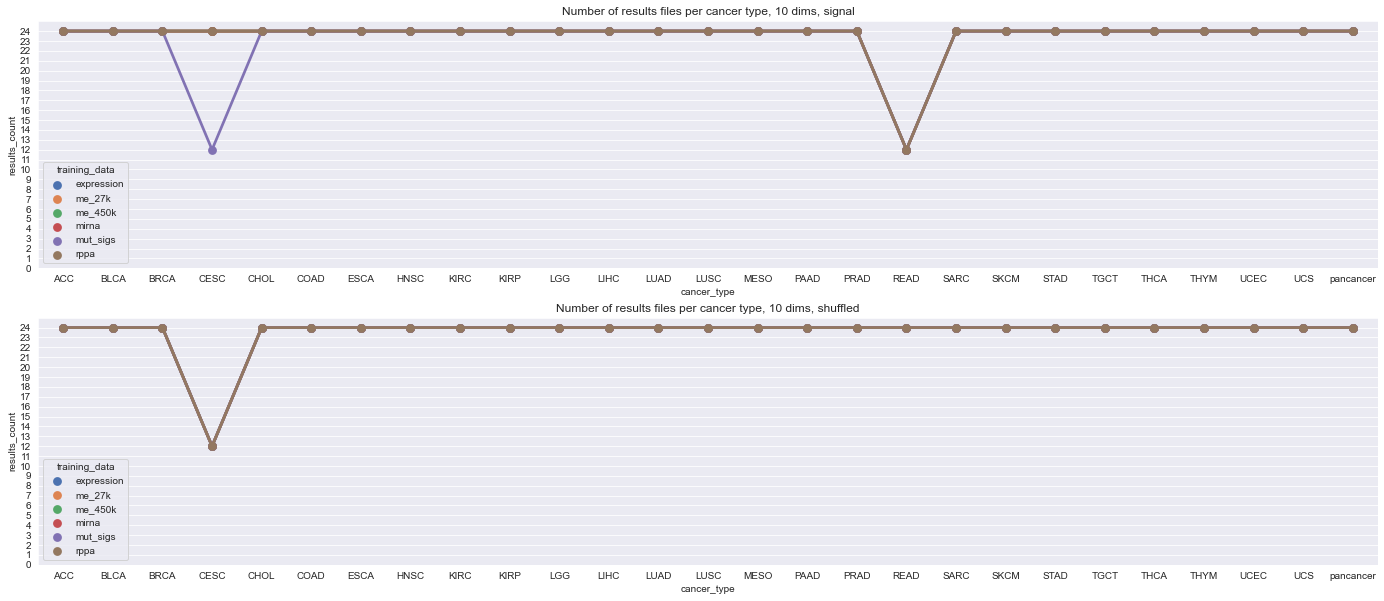

In [8]:
n_dim = 10

sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=count_df[(count_df.signal == 'signal') & (count_df.n_dim == n_dim)],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[0])
axarr[0].set_ylim(0, 25)
axarr[0].set_yticks(range(0, 25))
axarr[0].set_title('Number of results files per cancer type, {} dims, signal'.format(n_dim))

sns.pointplot(data=count_df[(count_df.signal == 'shuffled') & (count_df.n_dim == n_dim)],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[1])
axarr[1].set_ylim(0, 25)
axarr[1].set_yticks(range(0, 25))
axarr[1].set_title('Number of results files per cancer type, {} dims, shuffled'.format(n_dim))

### Identify failed model fits, expression vs. methylation

In [9]:
# in the cross-validation code, we set the cindex to exactly 0.5 for certain errors
# this prevents the training loop from breaking, but it means we have to identify them post hoc
me_all_results_df['failed_fit'] = (me_all_results_df.cindex == 0.5)
print(me_all_results_df.failed_fit.sum())
me_all_results_df.head()

16


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim,failed_fit
0,0.97443,train,PCPG,expression,signal,1,0,10,False
1,0.97443,cv,PCPG,expression,signal,1,0,10,False
2,0.22137,test,PCPG,expression,signal,1,0,10,False
3,0.88533,train,PCPG,expression,signal,1,1,10,False
4,0.88533,cv,PCPG,expression,signal,1,1,10,False


In [10]:
failed_summary_df = (me_all_results_df
    .loc[(me_all_results_df.data_type == 'test') &
         (me_all_results_df.signal == 'signal') &
         (me_all_results_df.n_dim == 10), :]
    .groupby(['cancer_type', 'training_data'])
    .sum()
)[['failed_fit']]

failed_summary_df.reset_index(inplace=True)
failed_summary_df.head()

,cancer_type,training_data,failed_fit
0,ACC,expression,0
1,ACC,me_27k,0
2,ACC,me_450k,0
3,BLCA,expression,0
4,BLCA,me_27k,0


Text(0.5, 1.0, 'Number of failed fits per cancer type')

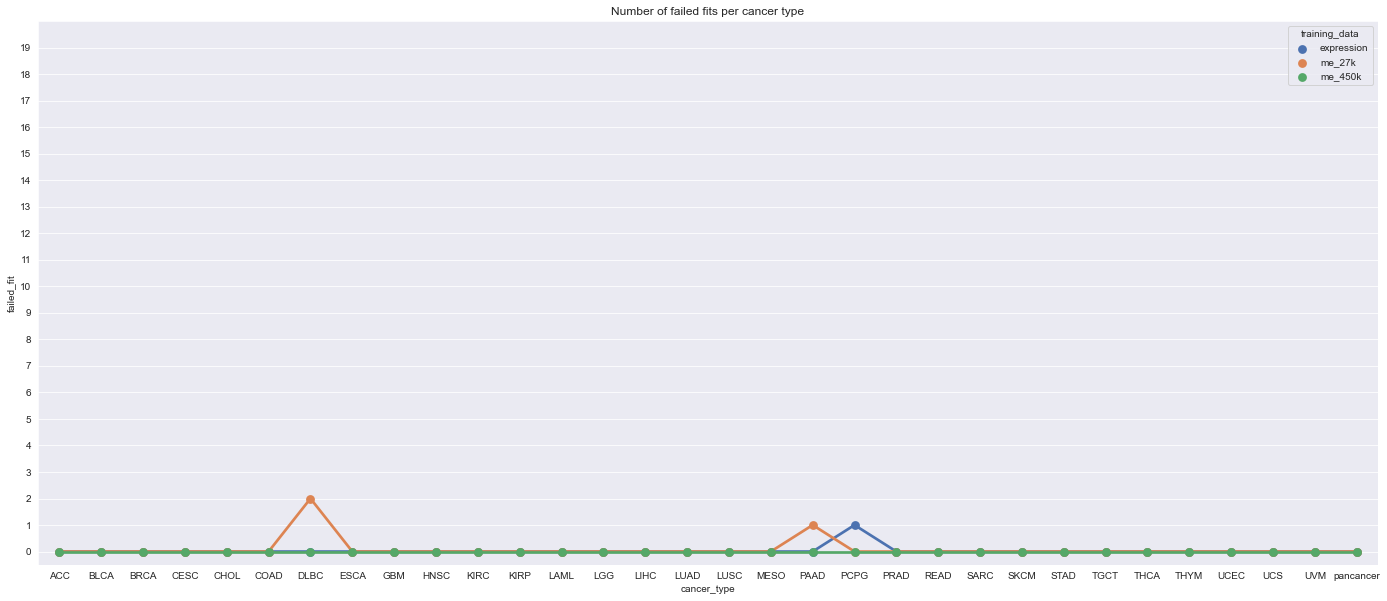

In [11]:
sns.set({'figure.figsize': (24, 10)})
sns.pointplot(data=failed_summary_df, x='cancer_type', y='failed_fit', hue='training_data')
plt.ylim(-0.5, 20)
plt.yticks(range(0, 20))
plt.title('Number of failed fits per cancer type')

### Identify failed model fits, all data types

In [12]:
# in the cross-validation code, we set the cindex to exactly 0.5 for certain errors
# this prevents the training loop from breaking, but it means we have to identify them post hoc
all_all_results_df['failed_fit'] = (all_all_results_df.cindex == 0.5)
print(all_all_results_df.failed_fit.sum())
all_all_results_df.head()

30


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim,failed_fit
0,0.82877,train,ACC,me_450k,shuffled,1,0,10,False
1,0.82877,cv,ACC,me_450k,shuffled,1,0,10,False
2,0.91667,test,ACC,me_450k,shuffled,1,0,10,False
3,0.78947,train,ACC,me_450k,shuffled,1,1,10,False
4,0.78947,cv,ACC,me_450k,shuffled,1,1,10,False


In [13]:
failed_summary_df = (all_all_results_df
    .loc[(all_all_results_df.data_type == 'test') &
         (all_all_results_df.signal == 'signal') &
         (all_all_results_df.n_dim == 10), :]
    .groupby(['cancer_type', 'training_data'])
    .sum()
)[['failed_fit']]

failed_summary_df.reset_index(inplace=True)
failed_summary_df.head()

,cancer_type,training_data,failed_fit
0,ACC,expression,0
1,ACC,me_27k,0
2,ACC,me_450k,0
3,ACC,mirna,0
4,ACC,mut_sigs,1


Text(0.5, 1.0, 'Number of failed fits per cancer type')

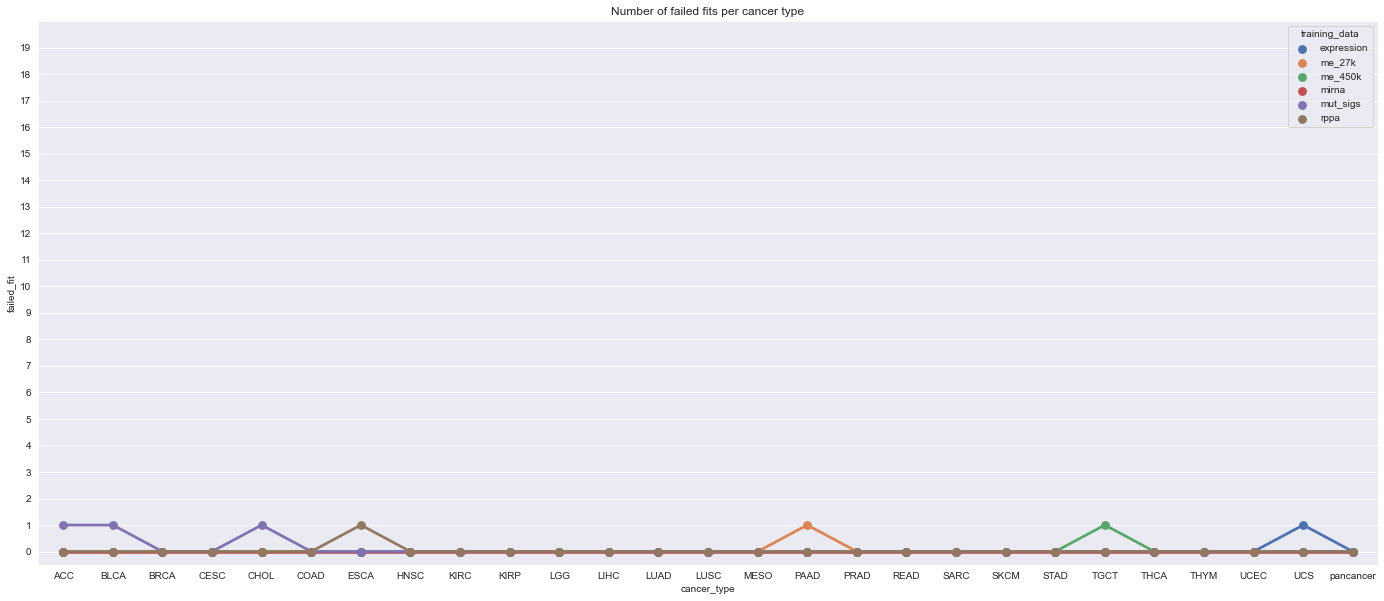

In [14]:
sns.set({'figure.figsize': (24, 10)})
sns.pointplot(data=failed_summary_df, x='cancer_type', y='failed_fit', hue='training_data')
plt.ylim(-0.5, 20)
plt.yticks(range(0, 20))
plt.title('Number of failed fits per cancer type')

### Count results files, expression vs. methylation baseline

In [15]:
# get baseline predictor results, using non-omics covariates only
me_baseline_results_df = su.load_survival_results(me_baseline_results_dir)
me_baseline_results_df.rename(columns={'identifier': 'cancer_type',
                                       'fold_no': 'fold'}, inplace=True)

print(me_baseline_results_df.shape)
print(me_baseline_results_df.training_data.unique())
me_baseline_results_df.head()

(1512, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58652,train,THCA,baseline,shuffled,42,0
1,0.58652,cv,THCA,baseline,shuffled,42,0
2,0.62935,test,THCA,baseline,shuffled,42,0
3,0.51779,train,THCA,baseline,shuffled,42,1
4,0.51779,cv,THCA,baseline,shuffled,42,1


In [16]:
# count the number of failed fits per cancer type/training data/n_dim
count_df = (me_baseline_results_df
    .groupby(['cancer_type', 'training_data', 'signal'])
    .count()
)[['cindex']]

count_df.rename(columns={'cindex': 'results_count'}, inplace=True)
count_df.reset_index(inplace=True)
count_df.head(10)

,cancer_type,training_data,signal,results_count
0,ACC,baseline,shuffled,24
1,ACC,baseline,signal,24
2,BLCA,baseline,shuffled,24
3,BLCA,baseline,signal,24
4,BRCA,baseline,shuffled,24
5,BRCA,baseline,signal,24
6,CESC,baseline,shuffled,24
7,CESC,baseline,signal,24
8,CHOL,baseline,shuffled,12
9,CHOL,baseline,signal,24


Text(0.5, 1.0, 'Number of results files per cancer type, baseline, shuffled')

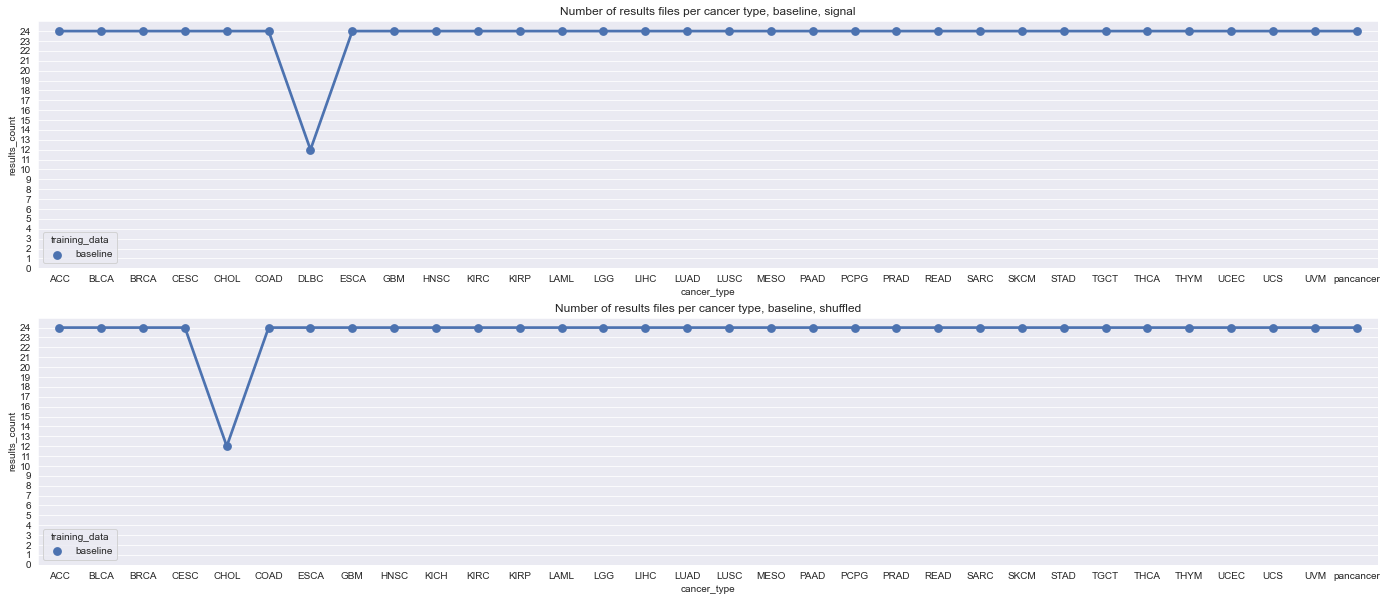

In [17]:
sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=count_df[(count_df.signal == 'signal')],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[0])
axarr[0].set_ylim(0, 25)
axarr[0].set_yticks(range(0, 25))
axarr[0].set_title('Number of results files per cancer type, baseline, signal')

sns.pointplot(data=count_df[(count_df.signal == 'shuffled')],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[1])
axarr[1].set_ylim(0, 25)
axarr[1].set_yticks(range(0, 25))
axarr[1].set_title('Number of results files per cancer type, baseline, shuffled')

### Count results files, all data baseline

In [21]:
# get baseline predictor results, using non-omics covariates only
all_baseline_results_df = su.load_survival_results(all_baseline_results_dir)
all_baseline_results_df.rename(columns={'identifier': 'cancer_type',
                                       'fold_no': 'fold'}, inplace=True)

print(all_baseline_results_df.shape)
print(all_baseline_results_df.training_data.unique())
all_baseline_results_df.head()

(1272, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.52347,train,THCA,baseline,shuffled,42,0
1,0.52347,cv,THCA,baseline,shuffled,42,0
2,0.27342,test,THCA,baseline,shuffled,42,0
3,0.61836,train,THCA,baseline,shuffled,42,1
4,0.61836,cv,THCA,baseline,shuffled,42,1


In [22]:
# count the number of failed fits per cancer type/training data/n_dim
count_df = (all_baseline_results_df
    .groupby(['cancer_type', 'training_data', 'signal'])
    .count()
)[['cindex']]

count_df.rename(columns={'cindex': 'results_count'}, inplace=True)
count_df.reset_index(inplace=True)
count_df.head(10)

,cancer_type,training_data,signal,results_count
0,ACC,baseline,shuffled,24
1,ACC,baseline,signal,24
2,BLCA,baseline,shuffled,24
3,BLCA,baseline,signal,24
4,BRCA,baseline,shuffled,24
5,BRCA,baseline,signal,24
6,CESC,baseline,shuffled,12
7,CESC,baseline,signal,24
8,CHOL,baseline,shuffled,24
9,CHOL,baseline,signal,24


Text(0.5, 1.0, 'Number of results files per cancer type, baseline, shuffled')

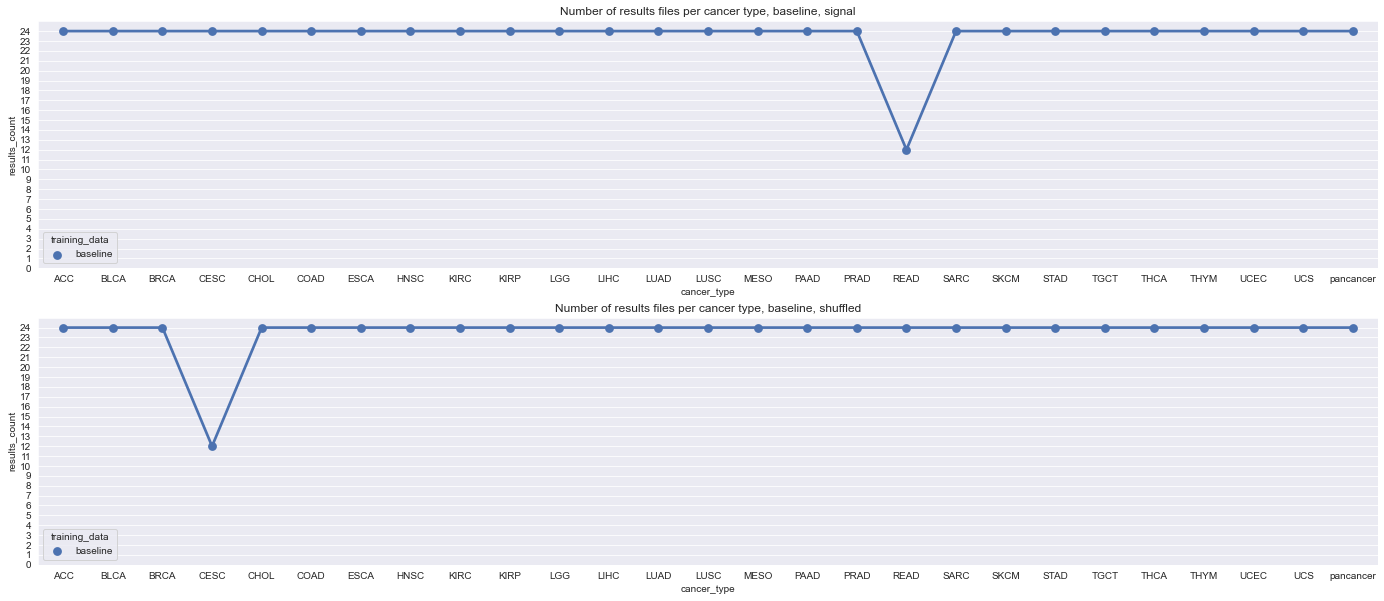

In [23]:
sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=count_df[(count_df.signal == 'signal')],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[0])
axarr[0].set_ylim(0, 25)
axarr[0].set_yticks(range(0, 25))
axarr[0].set_title('Number of results files per cancer type, baseline, signal')

sns.pointplot(data=count_df[(count_df.signal == 'shuffled')],
              x='cancer_type', y='results_count', hue='training_data', ax=axarr[1])
axarr[1].set_ylim(0, 25)
axarr[1].set_yticks(range(0, 25))
axarr[1].set_title('Number of results files per cancer type, baseline, shuffled')

### Identify failed model fits, expression vs. methylation, baseline

In [18]:
# in the cross-validation code, we set the cindex to exactly 0.5 for certain errors
# this prevents the training loop from breaking, but it means we have to identify them post hoc
me_baseline_results_df['failed_fit'] = (me_baseline_results_df.cindex == 0.5)
print(me_baseline_results_df.failed_fit.sum())
me_baseline_results_df.head()

5


,cindex,data_type,cancer_type,training_data,signal,seed,fold,failed_fit
0,0.58652,train,THCA,baseline,shuffled,42,0,False
1,0.58652,cv,THCA,baseline,shuffled,42,0,False
2,0.62935,test,THCA,baseline,shuffled,42,0,False
3,0.51779,train,THCA,baseline,shuffled,42,1,False
4,0.51779,cv,THCA,baseline,shuffled,42,1,False


In [19]:
failed_summary_df = (me_baseline_results_df
    .loc[(me_baseline_results_df.data_type == 'test')]
    .groupby(['cancer_type', 'signal'])
    .sum()
)[['failed_fit']]

failed_summary_df.reset_index(inplace=True)
failed_summary_df.head()

,cancer_type,signal,failed_fit
0,ACC,shuffled,0
1,ACC,signal,0
2,BLCA,shuffled,0
3,BLCA,signal,0
4,BRCA,shuffled,0


Text(0.5, 1.0, 'Number of failed fits per cancer type, baseline, shuffled')

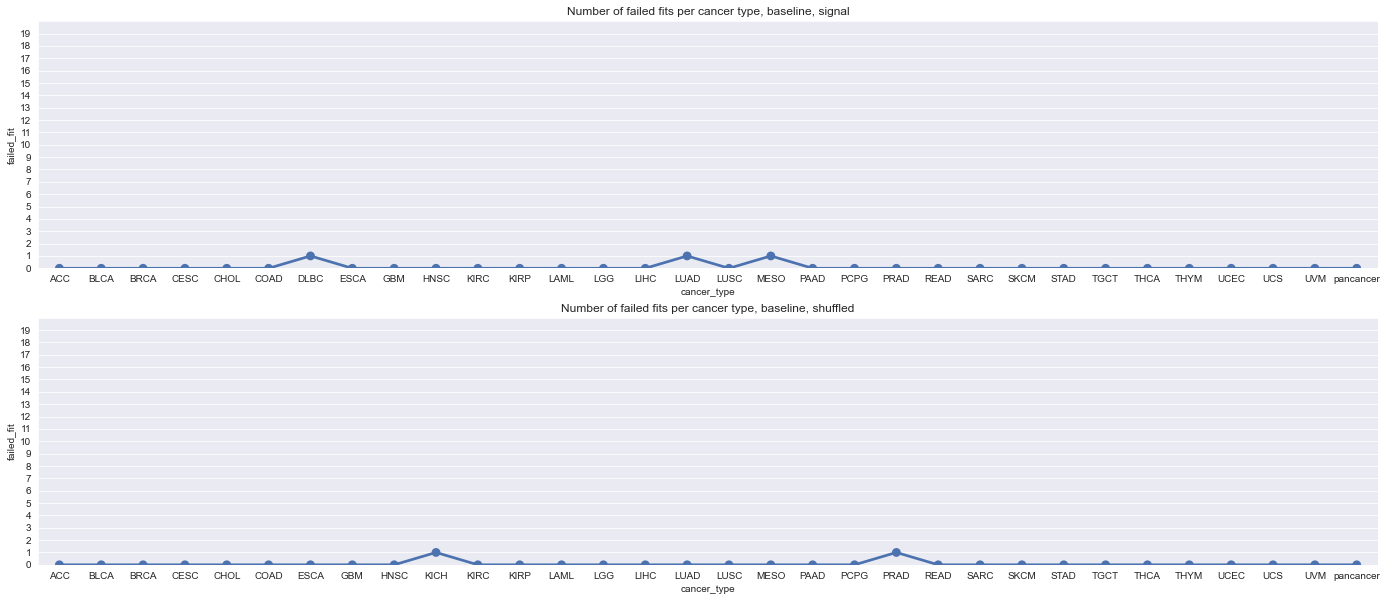

In [20]:
sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=failed_summary_df[failed_summary_df.signal == 'signal'],
              x='cancer_type', y='failed_fit', ax=axarr[0])
axarr[0].set_ylim(0, 20)
axarr[0].set_yticks(range(0, 20))
axarr[0].set_title('Number of failed fits per cancer type, baseline, signal')

sns.pointplot(data=failed_summary_df[failed_summary_df.signal == 'shuffled'],
              x='cancer_type', y='failed_fit', ax=axarr[1])
axarr[1].set_ylim(0, 20)
axarr[1].set_yticks(range(0, 20))
axarr[1].set_title('Number of failed fits per cancer type, baseline, shuffled')

### Identify failed model fits, all data, baseline

In [24]:
# in the cross-validation code, we set the cindex to exactly 0.5 for certain errors
# this prevents the training loop from breaking, but it means we have to identify them post hoc
all_baseline_results_df['failed_fit'] = (all_baseline_results_df.cindex == 0.5)
print(all_baseline_results_df.failed_fit.sum())
all_baseline_results_df.head()

4


,cindex,data_type,cancer_type,training_data,signal,seed,fold,failed_fit
0,0.52347,train,THCA,baseline,shuffled,42,0,False
1,0.52347,cv,THCA,baseline,shuffled,42,0,False
2,0.27342,test,THCA,baseline,shuffled,42,0,False
3,0.61836,train,THCA,baseline,shuffled,42,1,False
4,0.61836,cv,THCA,baseline,shuffled,42,1,False


In [25]:
failed_summary_df = (all_baseline_results_df
    .loc[(all_baseline_results_df.data_type == 'test')]
    .groupby(['cancer_type', 'signal'])
    .sum()
)[['failed_fit']]

failed_summary_df.reset_index(inplace=True)
failed_summary_df.head()

,cancer_type,signal,failed_fit
0,ACC,shuffled,0
1,ACC,signal,0
2,BLCA,shuffled,0
3,BLCA,signal,0
4,BRCA,shuffled,0


Text(0.5, 1.0, 'Number of failed fits per cancer type, baseline, shuffled')

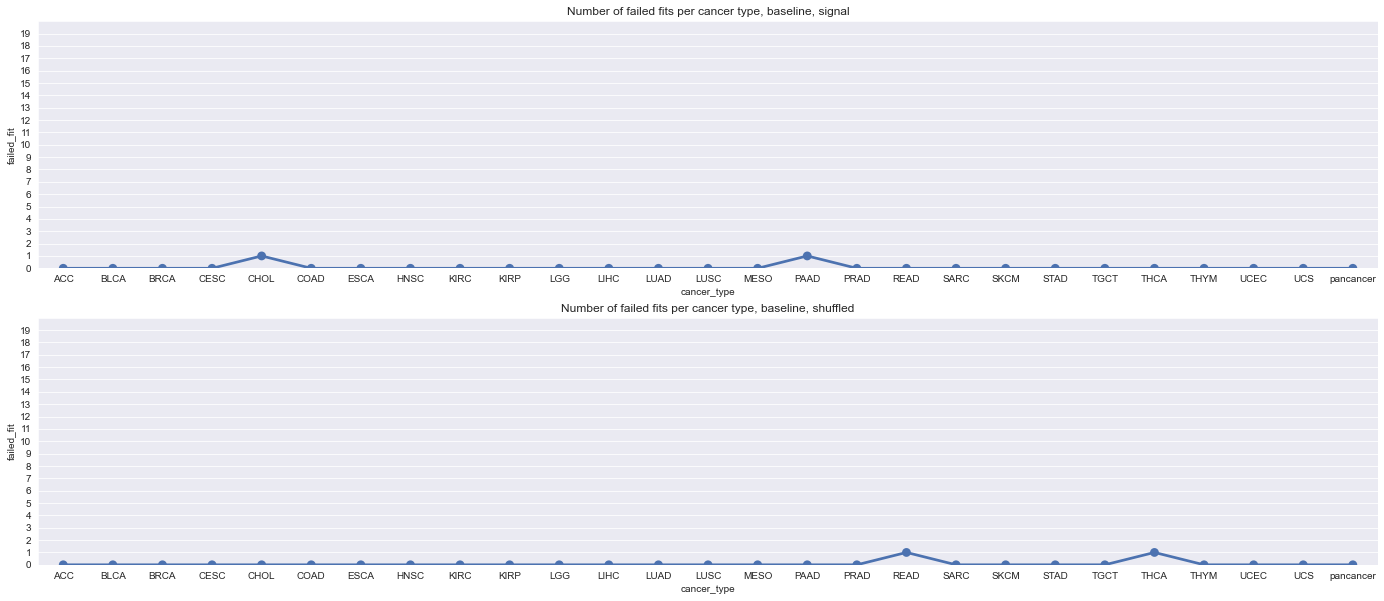

In [26]:
sns.set({'figure.figsize': (24, 10)})
fig, axarr = plt.subplots(2, 1)

sns.pointplot(data=failed_summary_df[failed_summary_df.signal == 'signal'],
              x='cancer_type', y='failed_fit', ax=axarr[0])
axarr[0].set_ylim(0, 20)
axarr[0].set_yticks(range(0, 20))
axarr[0].set_title('Number of failed fits per cancer type, baseline, signal')

sns.pointplot(data=failed_summary_df[failed_summary_df.signal == 'shuffled'],
              x='cancer_type', y='failed_fit', ax=axarr[1])
axarr[1].set_ylim(0, 20)
axarr[1].set_yticks(range(0, 20))
axarr[1].set_title('Number of failed fits per cancer type, baseline, shuffled')